In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,5)
sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv('/IT Expenditure dataset.xlsx - Future Data.csv')

In [ ]:
df.head()

,Date,Business Area,Region,Country,IT Sub Area,IT Area,Cost element name,Cost Element Group,Cost Element Sub Group,Actual
0,Sep,R&D,Europe,United Kingdom,Planning,BU Support,Payroll Taxes - Salaries,Labor,Internal Labor,437.99
1,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Auto Insurance,Other,Vehicles,90.54
2,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Bonuses,Labor,Internal Labor,7384.91
3,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Contractors,Labor,External Labor,7273.08
4,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Lease,Other,Vehicles,7.44


In [ ]:
df.shape, df.columns.tolist()
df.info()
df.head(8)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12119 entries, 0 to 12118
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    12119 non-null  object 
 1   Business Area           12119 non-null  object 
 2   Region                  12119 non-null  object 
 3   Country                 12119 non-null  object 
 4   IT Sub Area             12119 non-null  object 
 5   IT Area                 12119 non-null  object 
 6   Cost element name       12119 non-null  object 
 7   Cost Element Group      12119 non-null  object 
 8   Cost Element Sub Group  12119 non-null  object 
 9   Actual                  12119 non-null  float64
dtypes: float64(1), object(9)
memory usage: 946.9+ KB


,Date,Business Area,Region,Country,IT Sub Area,IT Area,Cost element name,Cost Element Group,Cost Element Sub Group,Actual
0,Sep,R&D,Europe,United Kingdom,Planning,BU Support,Payroll Taxes - Salaries,Labor,Internal Labor,437.99
1,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Auto Insurance,Other,Vehicles,90.54
2,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Bonuses,Labor,Internal Labor,7384.91
3,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Contractors,Labor,External Labor,7273.08
4,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Lease,Other,Vehicles,7.44
5,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Memberships,Other,Other,357.40
6,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Other Miscellaneous Expense,Other,Other,148.54
7,Sep,Distribution,Europe,United Kingdom,GRC,Governance,Payroll Taxes - Salaries,Labor,Internal Labor,14707.11


In [ ]:
# 1) strip whitespace from column names & string values
df.columns = df.columns.str.strip()
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# 2) parse date (if Date column contains month names like "Jan")
# Try multiple formats
def parse_date(x):
    try:
        return pd.to_datetime(x, dayfirst=True)
    except:
        try:
            # if values like 'Jan' or 'Jan-2020'
            return pd.to_datetime(x, format='%b-%Y', errors='coerce')
        except:
            try:
                # Handle month abbreviations like 'Sep'
                return pd.to_datetime(x, format='%b', errors='coerce').dt.replace(year=datetime.now().year) # Assume current year if only month is given
            except:
                return pd.NaT

if 'Date' in df.columns:
    df['Date_parsed'] = df['Date'].apply(parse_date)

# 3) numeric conversion for amount columns (try to detect last numeric column automatically)
# If there's a column with numeric spends, identify numeric-like columns
numeric_cols = []
for c in df.columns[::-1]:
    # find first column that can be numeric
    try:
        test = pd.to_numeric(df[c].str.replace(',','').replace('nan',''), errors='coerce')
        if test.notna().sum() > 0:
            numeric_cols.append(c)
    except Exception:
        pass

numeric_cols = list(dict.fromkeys(numeric_cols))
print("Potential numeric columns (from right to left):", numeric_cols[:4])

# If you know the amount column name (e.g. 'Actual' or numeric column), set:
amount_col = None
for candidate in ['Actual','Amount','Value','Cost','Cost Amount','Plan','Forecast','Actual Forecast Plan']:
    if candidate in df.columns:
        amount_col = candidate
        break

# fallback to first detected numeric column
if amount_col is None and numeric_cols:
    amount_col = numeric_cols[0]

print("Using amount column:", amount_col)
df[amount_col] = pd.to_numeric(df[amount_col].astype(str).str.replace(',',''), errors='coerce')

# remove duplicate rows
df = df.drop_duplicates()

Potential numeric columns (from right to left): []
Using amount column: Actual


In [ ]:
# derive Year, Month, MonthYear
if 'Date_parsed' in df.columns:
    df['Year'] = df['Date_parsed'].dt.year
    df['Month'] = df['Date_parsed'].dt.month
    df['MonthYear'] = df['Date_parsed'].dt.to_period('M')

# summary
print("Total records:", len(df))
print("Total spend (sum):", df[amount_col].sum(skipna=True))
df[amount_col].describe()


Total records: 11978
Total spend (sum): 309752304.18


,Actual
count,1.197800e+04
mean,2.586010e+04
std,3.943946e+05
min,-1.583700e+07
25%,2.077950e+02
50%,1.722675e+03
75%,1.000024e+04
max,1.320400e+07


In [ ]:
top_country = df.groupby('Country')[amount_col].sum().sort_values(ascending=False).head(10)
top_cost_group = df.groupby('Cost Element Group')[amount_col].sum().sort_values(ascending=False).head(10)
print("Top countries:\n", top_country)
print("\nTop cost groups:\n", top_cost_group)

if 'MonthYear' in df.columns and 'Region' in df.columns:
    monthly_region = df.groupby(['MonthYear','Region'])[amount_col].sum().unstack(fill_value=0)
    monthly_region = monthly_region.sort_index()
    monthly_region.head()


Top countries:
 Country
USA               2.578280e+08
United Kingdom    1.555238e+07
France            5.864583e+06
Germany           4.313135e+06
Puerto Rico       3.318262e+06
Belgium           3.113503e+06
Italy             2.670598e+06
Spain             2.637382e+06
Ireland           2.447105e+06
New Zealand       2.418653e+06
Name: Actual, dtype: float64

Top cost groups:
 Cost Element Group
Labor                  1.645640e+08
Depr & Amort           6.388387e+07
Hardware & Software    5.972646e+07
Other                  2.111371e+07
Shared Services        4.643120e+05
Name: Actual, dtype: float64


Monthly total data is empty, cannot plot monthly trend.


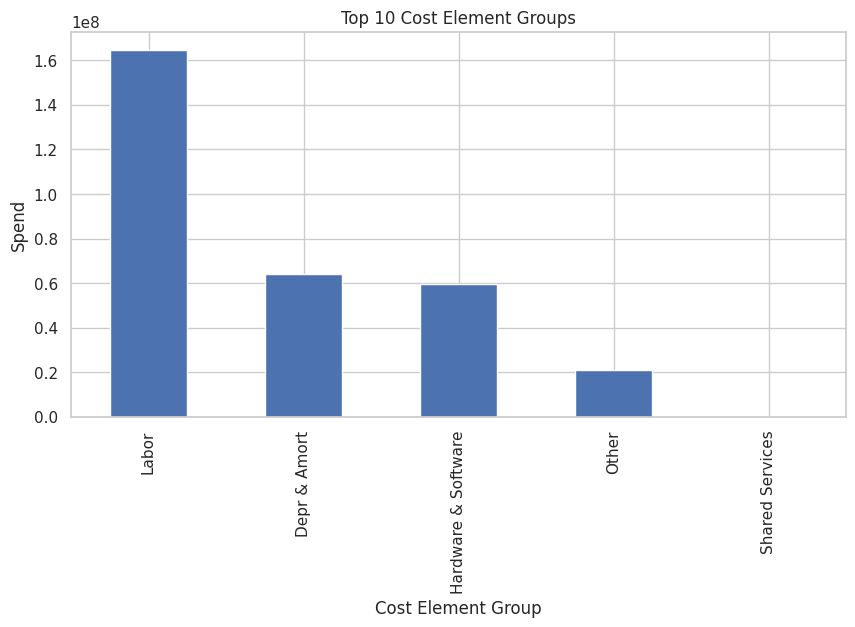

Heatmap data is empty, cannot plot heatmap.


In [ ]:
# 1) global monthly trend
if 'MonthYear' in df.columns:
    monthly_total = df.groupby('MonthYear')[amount_col].sum()
    # Ensure monthly_total is not empty before converting index and plotting
    if not monthly_total.empty:
        monthly_total.index = monthly_total.index.to_timestamp()
        monthly_total.plot(kind='line', marker='o', title='Monthly Total Spend')
        plt.ylabel('Spend')
        plt.show()
    else:
        print("Monthly total data is empty, cannot plot monthly trend.")


# 2) top 10 cost groups bar
top_cost_group.plot(kind='bar', title='Top 10 Cost Element Groups')
plt.ylabel('Spend')
plt.show()

# 3) heatmap: month vs region
if 'Month' in df.columns and 'Region' in df.columns:
    heat = df.groupby(['Region','Month'])[amount_col].sum().unstack(fill_value=0)
    # Ensure heat is not empty before plotting heatmap
    if not heat.empty:
        sns.heatmap(heat, annot=False, fmt=".0f", cmap="YlGnBu")
        plt.title('Region vs Month Spend')
        plt.ylabel('Region')
        plt.xlabel('Month')
        plt.show()
    else:
        print("Heatmap data is empty, cannot plot heatmap.")

In [ ]:
mean = df[amount_col].mean()
std = df[amount_col].std()
outliers = df[df[amount_col] > mean + 3*std].sort_values(amount_col, ascending=False)
outliers.head(20)


,Date,Business Area,Region,Country,IT Sub Area,IT Area,Cost element name,Cost Element Group,Cost Element Sub Group,Actual,Date_parsed,Year,Month,MonthYear
11876,Dec,Infrastructure,USA,USA,Core Infrastructure,Infrastructure,Adjustments,Shared Services,Outbound Allocations,13204000.00,NaT,NaN,NaN,NaT
5724,Oct,Infrastructure,USA,USA,Core Infrastructure,Infrastructure,Adjustments,Shared Services,Outbound Allocations,13079000.00,NaT,NaN,NaN,NaT
8764,Nov,Infrastructure,USA,USA,Core Infrastructure,Infrastructure,Adjustments,Shared Services,Outbound Allocations,12520000.00,NaT,NaN,NaN,NaT
2718,Sep,Infrastructure,USA,USA,Core Infrastructure,Infrastructure,Adjustments,Shared Services,Outbound Allocations,12003000.00,NaT,NaN,NaN,NaT
11570,Dec,Infrastructure,USA,USA,Core Infrastructure,Infrastructure,Outsourcing,Labor,External Labor,4418678.38,NaT,NaN,NaN,NaT
10043,Dec,Office & Administrative,USA,USA,R2,Functional,Software,Depr & Amort,Amortization,3356067.08,NaT,NaN,NaN,NaT
983,Sep,Office & Administrative,USA,USA,R2,Functional,Software,Depr & Amort,Amortization,3344704.04,NaT,NaN,NaN,NaT
10940,Dec,Infrastructure,USA,USA,Productivity,Infrastructure,Computer Hardware,Hardware & Software,Hardware,3344179.73,NaT,NaN,NaN,NaT
3984,Oct,Office & Administrative,USA,USA,R2,Functional,Software,Depr & Amort,Amortization,3243917.92,NaT,NaN,NaN,NaT
6988,Nov,Office & Administrative,USA,USA,R2,Functional,Software,Depr & Amort,Amortization,3117548.51,NaT,NaN,NaN,NaT


In [ ]:
# Colab cell 9: export cleaned version
cleaned_path = "/content/it_expenditure_cleaned.csv"
df.to_csv(cleaned_path, index=False)
print("Saved cleaned CSV to", cleaned_path)


Saved cleaned CSV to /content/it_expenditure_cleaned.csv
